# Ride Duration Prediction (For-Hire Vehicle Trip Records)

The goal of this homework is to train a simple model for predicting the duration of a ride

## Data

We'll use [For-Hire Vehicle Trip Records](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) dataset.

We'll focus on January and February 2021.

## Q1. January 2021: How many records are there?

In [1]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [113]:
def read_dataframe(filename):
    return pd.read_parquet(filename)

In [5]:
df_january = read_dataframe('./data/fhv_tripdata_2021-01.parquet')

In [6]:
len(df_january)

1154112

The solution is **1154112**

## Q2. Computing duration

In [11]:
df_january.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


In [12]:
def compute_duration(df):
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    return df

In [13]:
df_january = compute_duration(df_january)

In [14]:
average_trip_duration = df_january['duration'].mean()
average_trip_duration

19.167224093791006

The solution is **19.16**

## Data Preparation

Check the distribution of the duration variable. There are some outliers.

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop?

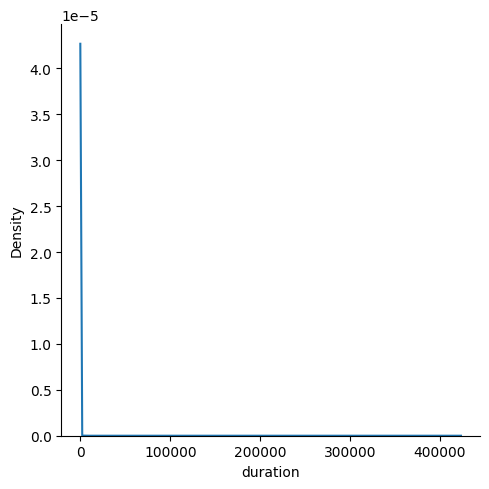

In [22]:
sns.displot(df_january, x="duration",  kind="kde")

In [18]:
def remove_duration_outliers(df):
    new_df = df.copy()
    new_df = new_df[(new_df.duration >= 1) & (new_df.duration <= 60)]
    return new_df

In [19]:
df_january_duration = remove_duration_outliers(df_january)

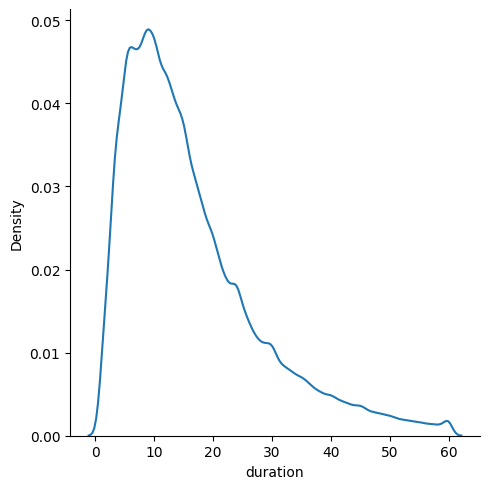

In [24]:
sns.displot(df_january_duration, x="duration",  kind="kde")

In [25]:
# How many records did we drop?
len(df_january) - len(df_january_duration)

44286

We dropped **44286** records

## Q3. Missing values

In [92]:
categorical = ['PUlocationID', 'DOlocationID']

In [95]:
def fillna_locationID(df):
    new_df = df.copy()
    new_df[categorical] = new_df[categorical].fillna(-1).astype('int')
    new_df[categorical] = new_df[categorical].astype('str')
    return new_df

In [96]:
df_january_duration_fillna = fillna_locationID(df_january_duration)

In [101]:
percentage_counts = df_january_duration_fillna['PUlocationID'].value_counts(normalize=True, dropna=False).mul(100).round(1).astype(str) + '%'
percentage_counts.loc["-1"]

'83.5%'

The fraction of missing values is **83.5%**

## Q4. One-hot encoding

In [102]:
dicts = df_january_duration_fillna[categorical].to_dict(orient='records')
dv = DictVectorizer()
dv.fit(dicts)
def one_hot_encoding(df):
    dicts = df[categorical].to_dict(orient='records')
    X = dv.transform(dicts)
    return X

In [103]:
X_train = one_hot_encoding(df_january_duration_fillna)

In [104]:
X_train.shape

(1109826, 525)

The dimensionality of the training matrix is **(1109826, 525)**: 1109826 samples and 525 features

## Q5. Training a model

In [106]:
target = 'duration'
y_train = df_january_duration_fillna[target].values

In [114]:
def validate_lr(lr, X, y):
    y_pred = lr.predict(X)
    mse = mean_squared_error(y, y_pred, squared=False)
    
    return mse, y_pred

def train_lr(X, y):
    lr = LinearRegression()
    lr.fit(X, y)
    mse, _ = validate_lr(lr, X, y)
    print(mse)
    
    return lr

In [115]:
lr = train_lr(X_train, y_train)

10.528519421155469


The RMSE on the training data is **10.52**

## Q6. Evaluating the model

In [116]:
# Create generic load and preprocess function
def load_preprocess_dataframe(filename, target='duration'):
    df = read_dataframe(filename)
    df = compute_duration(df)
    df = remove_duration_outliers(df)
    df = fillna_locationID(df)
    X = one_hot_encoding(df)
    y = df[target].values
    
    return X, y

In [117]:
# Load validation data
X_val, y_val = load_preprocess_dataframe('./data/fhv_tripdata_2021-02.parquet')
X_val.shape

(990113, 525)

In [118]:
mse, y_pred = validate_lr(lr, X_val, y_val)
print(mse)

11.01428736186454


The RMSE on the training data is **11.01**

/var/folders/q8/6pzc9r955kd8whj1ss97qt080000gn/T/ipykernel_22582/2624495092.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/q8/6pzc9r955kd8whj1ss97qt080000gn/T/ipykernel_22582/2624495092.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_val, label

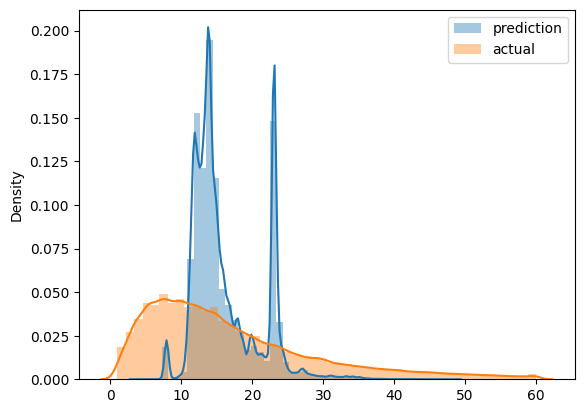

In [119]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_val, label='actual')

plt.legend()